#### **MODELING**
This notebook implements machine learning models based on the comprehensive EDA findings and preprocessing recommendations. We follow an evidence-based approach to ensure the modeling strategy aligns with the data characteristics and patterns identified earlier.

**Modeling Strategy**

1. Model Selection – Logistic Regression (baseline), Random Forest, and XGBoost (EDA recommendations)

2. Model Evaluation – Confusion matrix, classification report, ROC-AUC, balanced accuracy, and macro F1
3. Explainability – SHAP values and model coefficients for feature interpretation

**EDA Evidence for Modeling**
1. Non-linear interactions – Use tree-based models (Random Forest, XGBoost) to capture complex feature relationships

2. Production focus – Select interpretable and stable models suitable for deployment and policy insights

#### **1. Import Libraries and Load Preprocessed Data**

In [1]:
#Core Libaries
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings("ignore")

# Machine learning libaries
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import cross_val_score, GridSearchCV
from sklearn.metrics import (classification_report,confusion_matrix, accuracy_score,balanced_accuracy_score,f1_score,precision_score,recall_score)
from sklearn.preprocessing import StandardScaler
import joblib

#Advanced ML Libraries
try:
    import xgboost as xgb
    XGBOOST_AVAILABLE = True
except ImportError:
    XGBOOST_AVAILABLE = False
    print("XGBoost not available. Install with: pip install xgboost")

try:
    import lightgbm as lgb
    LIGHTGBM_AVAILABLE = True
except ImportError:
    LIGHTGBM_AVAILABLE = False
    print("LightGBM not available. Install with: pip install lightgbm")

# Explainability
try:
    import shap
    SHAP_AVAILABLE = True
except ImportError:
    SHAP_AVAILABLE = False
    print("SHAP not available. Install with: pip install shap")

# Set style for better visualizations
plt.style.use('seaborn-v0_8')
sns.set_palette("husl")

print("Libraries imported successfully!")
print(f"XGBoost available: {XGBOOST_AVAILABLE}")
print(f"LightGBM available: {LIGHTGBM_AVAILABLE}")
print(f"SHAP available: {SHAP_AVAILABLE}")

Libraries imported successfully!
XGBoost available: True
LightGBM available: True
SHAP available: True


In [2]:
#load preprocessed datasets
print("LOADING PREPROCESSED DATA")

try:
    # load preprocessed datasets
    X_train = pd.read_csv("scaled_X_train.csv")
    X_test = pd.read_csv("scaled_X_test.csv")

    y_train = pd.read_csv("y_train.csv").squeeze()
    y_test = pd.read_csv("y_test.csv").squeeze()
     ### The .squeeze() method removes dimensions of size 1, converting a DataFrame to a Series
    ### The .squeeze() method is a clean, robust way to ensure your target variables are in the correct 1D format that sklearn expects, 
    ### preventing potential errors during model training and evaluation.

    #Load preprocessing objects
    scaler = joblib.load("scaler.pkl")
    selected_features = joblib.load("selected_features.pkl")

    print("...Preprocessed data loaded successfully!!....")
    print(f"Training set: {X_train.shape}")
    print(f"Test set: {X_test.shape}")

      # Display class distribution
    print("\nClass distribution:")
    print("Training set:")
    print(y_train.value_counts().sort_index())
    print("\nValidation set:")
    print("\nTest set:")
    print(y_test.value_counts().sort_index())

     # Display selected features
    print(f"\nSelected features ({len(selected_features)}):")
    for i, feature in enumerate(selected_features, 1):
        print(f"{i:2d}. {feature}")


except FileNotFoundError as e:
    print(f"Error loading preprocessed data: {e}")
    print("Please run the preprocessing notebook first to generate the required files.")
    print("Required files: X_train_scaled.csv,  X_test_scaled.csv")
    print("\ny_train.csv,y_test.csv")
    print("\nscaler.pkl, selected_features.pkl")

    




LOADING PREPROCESSED DATA
...Preprocessed data loaded successfully!!....
Training set: (675, 15)
Test set: (169, 15)

Class distribution:
Training set:
Loan_Status
0    328
1    347
Name: count, dtype: int64

Validation set:

Test set:
Loan_Status
0    94
1    75
Name: count, dtype: int64

Selected features (15):
 1. Gender
 2. Married
 3. Dependents
 4. Education
 5. Self_Employed
 6. Credit_History
 7. Property_Area
 8. Loan_Amount_Term_ in_year
 9. Income_Category
10. Has_Coapplicant
11. ApplicantIncome_log
12. CoapplicantIncome_log
13. LoanAmount_log
14. Total_income_log
15. EMI_log


#### **2. Baseline Model - Logistic Regression**

In [3]:
# Baseline Logistic Regression Model
print("BASELINE LOGISTIC REGRESSION MODEL")
print("EDA recommendation: Fast, interpretable baseline with coefficients for feature effect direction")


 # create and train baseline model
baseline_model = LogisticRegression(
    random_state=234,
    max_iter=1000)
# Train model
baseline_model.fit(X_train, y_train)

# Make predictions
y_train_pred = baseline_model.predict(X_train)
y_test_pred = baseline_model.predict(X_test)

# Calculate metrics
train_accuracy = accuracy_score(y_train, y_train_pred)
test_accuracy = accuracy_score(y_test, y_test_pred)

train_f1 = f1_score(y_train, y_train_pred, average='binary')
test_f1 = f1_score(y_test, y_test_pred, average='binary')

print(f"\nBaseline Model Performance:")
print(f"Training - Accuracy: {train_accuracy:.3f}, , Binary F1: {train_f1:.3f}")

print(f"Test - Accuracy: {test_accuracy:.3f}, , Binary F1: {test_f1:.3f}")


# Display feature coefficients (interpretability)
print(f"\nFeature Coefficients (Top 10):")
feature_importance = pd.DataFrame({
    'feature': X_train.columns,
    'coefficient': baseline_model.coef_[0]
}).sort_values('coefficient', key=abs, ascending=False)

for i, (_, row) in enumerate(feature_importance.head(10).iterrows(), 1):
    print(f"{i:2d}. {row['feature']}: {row['coefficient']:.3f}")

# Store baseline results
baseline_results = {
    'model': 'Logistic Regression',
    'train_accuracy': train_accuracy,
    'test_accuracy': test_accuracy,
    'test_f1': test_f1
}

print(".... Baseline model completed!")



BASELINE LOGISTIC REGRESSION MODEL
EDA recommendation: Fast, interpretable baseline with coefficients for feature effect direction

Baseline Model Performance:
Training - Accuracy: 0.776, , Binary F1: 0.805
Test - Accuracy: 0.716, , Binary F1: 0.742

Feature Coefficients (Top 10):
 1. Married: 1.340
 2. Credit_History: 1.216
 3. Self_Employed: 1.017
 4. CoapplicantIncome_log: 0.875
 5. Has_Coapplicant: -0.649
 6. Income_Category: 0.564
 7. Property_Area: 0.531
 8. Total_income_log: -0.468
 9. ApplicantIncome_log: 0.423
10. EMI_log: -0.417
.... Baseline model completed!


#### **3. Random Forest Classifier (EDA Recommendation)**

RANDOM FOREST CLASSIFIER
EDA recommendation: Robust, captures interactions, insensitive to scaling and moderate outliers

Random Forest Performance:
Training - Accuracy: 1.000, ,Binary F1: 1.000
Test - Accuracy: 0.751,  Binary F1: 0.753

Feature Importance (Top 10):
 1. Credit_History: 0.287
 2. Total_income_log: 0.120
 3. ApplicantIncome_log: 0.110
 4. LoanAmount_log: 0.103
 5. EMI_log: 0.100
 6. CoapplicantIncome_log: 0.072
 7. Dependents: 0.048
 8. Property_Area: 0.035
 9. Income_Category: 0.025
10. Loan_Amount_Term_ in_year: 0.024


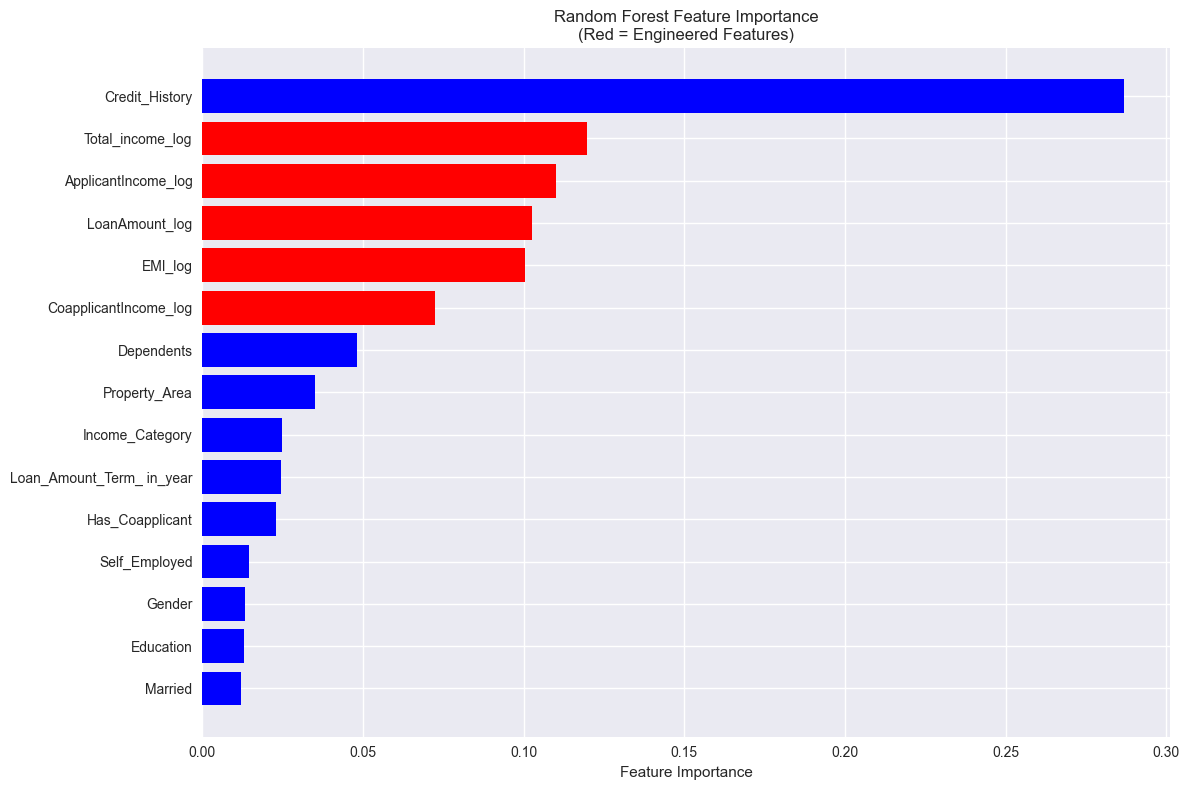

....Random Forest model completed...!


In [4]:
# Random Forest Classifier
print("RANDOM FOREST CLASSIFIER")
print("EDA recommendation: Robust, captures interactions, insensitive to scaling and moderate outliers")

#create random forest model
rf_model = RandomForestClassifier(
    n_estimators=100,
    random_state=42,
    n_jobs=-1
)
 # Train the model
rf_model.fit(X_train, y_train)

# Make Predictions
y_train_pred_rf = rf_model.predict(X_train)
y_test_pred_rf = rf_model.predict(X_test)

#Calculate metrics
train_accuracy_rf = accuracy_score(y_train, y_train_pred_rf)
test_accuracy_rf = accuracy_score(y_test, y_test_pred_rf)


train_f1_rf = f1_score(y_train, y_train_pred_rf, average='binary')
test_f1_rf = f1_score(y_test, y_test_pred_rf, average='binary')

print(f"\nRandom Forest Performance:")
print(f"Training - Accuracy: {train_accuracy_rf:.3f}, ,Binary F1: {train_f1_rf:.3f}")
print(f"Test - Accuracy: {test_accuracy_rf:.3f},  Binary F1: {test_f1_rf:.3f}")

# Feature importance analysis
print(f"\nFeature Importance (Top 10):")
feature_importance_rf = pd.DataFrame({
    'feature': X_train.columns,
    'importance': rf_model.feature_importances_
}).sort_values('importance', ascending=False)

for i, (_, row) in enumerate(feature_importance_rf.head(10).iterrows(), 1):
    print(f"{i:2d}. {row['feature']}: {row['importance']:.3f}")

# Visualize feature importance
plt.figure(figsize=(12, 8))
top_features_rf = feature_importance_rf.head(15)
colors = ['red' if any(keyword in f.lower() for keyword in ['ratio', 'interaction', 'balance', 'total', 'log']) else 'blue' for f in top_features_rf['feature']]

plt.barh(range(len(top_features_rf)), top_features_rf['importance'], color=colors)
plt.yticks(range(len(top_features_rf)), top_features_rf['feature'])
plt.xlabel('Feature Importance')
plt.title('Random Forest Feature Importance\n(Red = Engineered Features)')
plt.gca().invert_yaxis()
plt.tight_layout()
plt.show()

# Store Random Forest results
rf_results = {
    'model': 'Random Forest',
    'train_accuracy': train_accuracy_rf,
    'test_accuracy': test_accuracy_rf,
    'train_f1': train_f1_rf,
    'test_f1': test_f1_rf
}

print("....Random Forest model completed...!")


#### **4. XGBoost Classifier (EDA Recommendation)**

In [5]:
# XGBoost Classifier
print(".....XGBOOST CLASSIFIER....")
print("EDA recommendation: Best performance for structured data, handles non-linearity and feature interactions automatically")

if XGBOOST_AVAILABLE:
    # create XGBoost model
    xgb_model = xgb.XGBClassifier(
        n_estimators = 100,
        random_state=42,
        eval_metric="mlogloss",
        n_jobs=-1
    )

    # Train the  model (using encoded labels for XGBoost)
    xgb_model.fit(X_train, y_train)

    # Make Predictions
    y_train_pred_xgb = xgb_model.predict(X_train)
    y_test_pred_xgb = xgb_model.predict(X_test)

    #Calculate metrics using original label
    train_accuracy_xgb = accuracy_score(y_train,y_train_pred_xgb)
    test_accuracy_xgb = accuracy_score(y_test,y_test_pred_xgb)


    train_f1_xgb = f1_score(y_train, y_train_pred_xgb, average='binary')
    test_f1_xgb = f1_score(y_test, y_test_pred_xgb, average='binary')

    print(f"\nXGBoost Performance:")
    print(f"Training - Accuracy: {train_accuracy_xgb:.3f},  Binary F1: {train_f1_xgb:.3f}")
    print(f"Test - Accuracy: {test_accuracy_xgb:.3f}, Binary F1: {test_f1_xgb:.3f}")
        
        # Feature importance analysis
    print(f"\nFeature Importance (Top 10):")
    feature_importance_xgb = pd.DataFrame({
            'feature': X_train.columns,
            'importance': xgb_model.feature_importances_
        }).sort_values('importance', ascending=False)
        
    for i, (_, row) in enumerate(feature_importance_xgb.head(10).iterrows(), 1):
            print(f"{i:2d}. {row['feature']}: {row['importance']:.3f}")
        
    # Store XGBoost results
    xgb_results = {
            'model': 'XGBoost',
            'train_accuracy': train_accuracy_xgb,
            'test_accuracy': test_accuracy_xgb,
            'train_f1': train_f1_xgb,
            'test_f1': test_f1_xgb
        }
        
    print("XGBoost model completed!")

else:
    print("... XGBoost not available. Skipping XGBoost model.")
    xgb_results = None

.....XGBOOST CLASSIFIER....
EDA recommendation: Best performance for structured data, handles non-linearity and feature interactions automatically

XGBoost Performance:
Training - Accuracy: 1.000,  Binary F1: 1.000
Test - Accuracy: 0.769, Binary F1: 0.752

Feature Importance (Top 10):
 1. Credit_History: 0.453
 2. Income_Category: 0.077
 3. Has_Coapplicant: 0.061
 4. Self_Employed: 0.059
 5. Married: 0.052
 6. Loan_Amount_Term_ in_year: 0.050
 7. Total_income_log: 0.039
 8. Dependents: 0.036
 9. CoapplicantIncome_log: 0.032
10. Property_Area: 0.030
XGBoost model completed!


#### **5. Model Comparison and Evaluation**

MODEL COMPARISON AND EVALUATION

Model Performance Comparison:
Model           Train Acc  Test Acc   Test F1   
Logistic Regression 0.776       0.716       0.742     
Random Forest   1.000       0.751       0.753     
XGBoost         1.000       0.769       0.752     

Best Model: Random Forest (Test F1: 0.753)


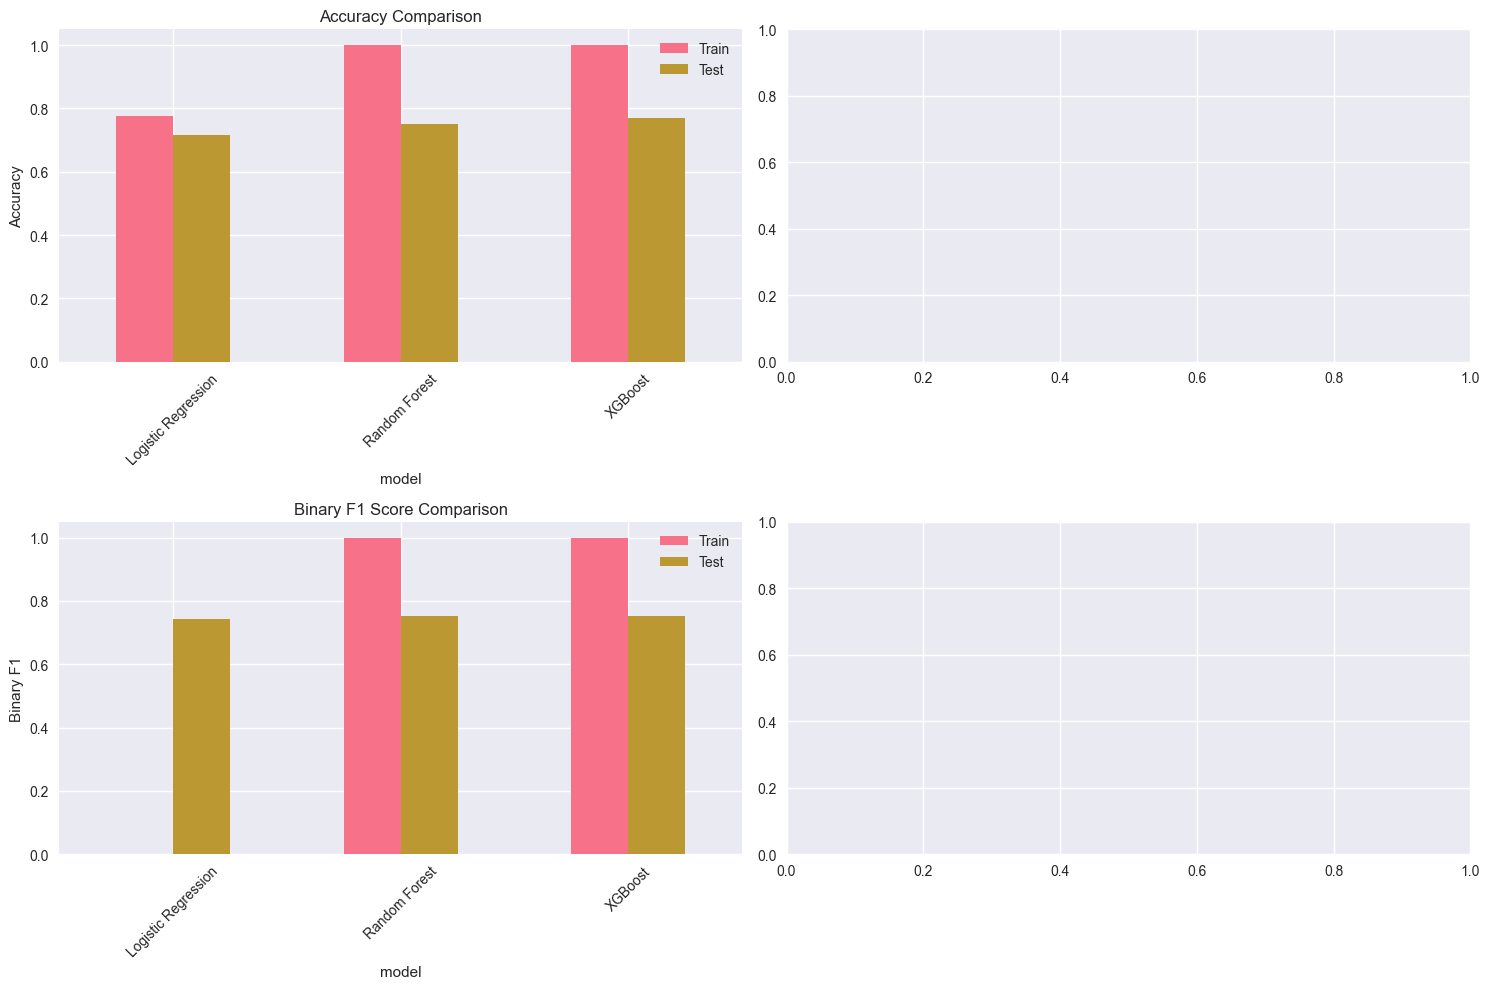

...Model comparison completed!


In [6]:

print("MODEL COMPARISON AND EVALUATION")

# Collect all results
all_results = [baseline_results, rf_results]
if xgb_results is not None:
    all_results.append(xgb_results)

# Create comparison DataFrame
comparison_df = pd.DataFrame(all_results)
comparison_df = comparison_df.set_index('model')

print("\nModel Performance Comparison:")
print("=" * 80)
print(f"{'Model':<15} {'Train Acc':<10} {'Test Acc':<10} {'Test F1':<10}")
print("=" * 80)
for _, row in comparison_df.iterrows():
    print(f"{row.name:<15} {row['train_accuracy']:<10.3f}  {row['test_accuracy']:<10.3f}  {row['test_f1']:<10.3f}")

# Find best model based on validation F1 score (EDA recommendation)
best_model_name = comparison_df['test_f1'].idxmax()
best_model_score = comparison_df.loc[best_model_name, 'test_f1']

print(f"\nBest Model: {best_model_name} (Test F1: {best_model_score:.3f})")

# Visualize model comparison
fig, axes = plt.subplots(2, 2, figsize=(15, 10))

# Accuracy comparison
comparison_df[['train_accuracy', 'test_accuracy']].plot(kind='bar', ax=axes[0,0])
axes[0,0].set_title('Accuracy Comparison')
axes[0,0].set_ylabel('Accuracy')
axes[0,0].legend(['Train', 'Test'])
axes[0,0].tick_params(axis='x', rotation=45)


# F1 Score comparison
comparison_df[['train_f1', 'test_f1']].plot(kind='bar', ax=axes[1,0])
axes[1,0].set_title('Binary F1 Score Comparison')
axes[1,0].set_ylabel('Binary F1')
axes[1,0].legend(['Train', 'Test'])
axes[1,0].tick_params(axis='x', rotation=45)



plt.tight_layout()
plt.show()

print("...Model comparison completed!")
